In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.optimize import curve_fit
import sympy as sym

#import scipy as sc
#import pandas as pd

import numpy.random as rndm
from numpy.random import uniform as UNFM
#from numpy.random import randint 
#from matplotlib.animation import FuncAnimation

import time
import os
import datetime
from datetime import datetime as dt

import scienceplots
plt.style.use(['science','notebook','grid'])

In [13]:
1e-3

0.001

In [18]:
import importlib
from src import PhotonBoxPropagationSimulator as Simulator
from src import LinearAttenuationCoeff_load as LAC_loader
importlib.reload(Simulator)
importlib.reload(LAC_loader)

# define parameters:
box_num_hvls = (3,10,10)
fp_mac = "../mac_NistXcom/mac_lead.txt"
lead_density = 11.34 # g/cm^3
lac_loader = LAC_loader.LACLoader(fp_mac,lead_density,"Svinec")
GPS_template = {
    "E0": 1,
    "r_entrance":0,
    "u_entrance":0,
}

# initialize simulator class instacne
simulator = Simulator.photon_box_propagation_simulator(
    box_num_hvls,
    lac_loader,
    GPS_template,
)



GPS_template: 
E0=1; r_entr=[-1.34773093  0.          0.        ]; u_entr=[1 0 0]


In [19]:
# simulate
simulator.simulate(
    Nsim=10000,
    doWrite=False
    )

Starting simulation: E=1; num_hvlX = 3; 10000 events


	Progress: 10.00%
	Progress: 20.00%
	Progress: 30.00%
	Progress: 40.00%
	Progress: 50.00%
	Progress: 60.00%
	Progress: 70.00%
	Progress: 80.00%
	Progress: 90.00%
Simulation completed.

Simulation Results:
  Deposited Energy:   8127.505833 MeV
  Backscattered:      26.850431 MeV
  Out Total:          1845.643736 MeV
  Leakage:            0.000000 MeV
  Total Simulated:    10000.000000 MeV
  Total Detected:     10000.000000 MeV
  Energy Balance:     0.000000 MeV (should be close to 0)
  Theoretical Out:    1250.000000 MeV

Buildup Factor Report:
  Incident Energy:    1.0000 MeV
  Number of HVLs:     3
  Number of Events:   10000
  Buildup Factor:     1.476515


In [15]:
simulator.report_results()

Simulation Results:
  Deposited Energy:   470516.918680 MeV
  Backscattered:      3929.340196 MeV
  Out Total:          25535.284572 MeV
  Leakage:            18.456552 MeV
  Total Simulated:    500000.000000 MeV
  Total Detected:     500000.000000 MeV
  Energy Balance:     -0.000000 MeV (should be close to 0)
  Theoretical Out:    15625.000000 MeV

Buildup Factor Report:
  Incident Energy:    5.0000 MeV
  Number of HVLs:     5
  Number of Events:   100000
  Buildup Factor:     1.634258


At 0.01 MeV, total linear attenuation coefficient is 1424.8188 /cm; (mean free path = 0.0007 cm)
At 0.05 MeV, total linear attenuation coefficient is 83.7661 /cm; (mean free path = 0.0119 cm)
At 0.08 MeV, total linear attenuation coefficient is 23.9413 /cm; (mean free path = 0.0418 cm)
At 0.1 MeV, total linear attenuation coefficient is 60.5096 /cm; (mean free path = 0.0165 cm)
At 0.15 MeV, total linear attenuation coefficient is 21.6576 /cm; (mean free path = 0.0462 cm)
At 0.5 MeV, total linear attenuation coefficient is 1.7000 /cm; (mean free path = 0.5882 cm)
At 1.0 MeV, total linear attenuation coefficient is 0.7715 /cm; (mean free path = 1.2962 cm)
At 2.0 MeV, total linear attenuation coefficient is 0.5137 /cm; (mean free path = 1.9465 cm)


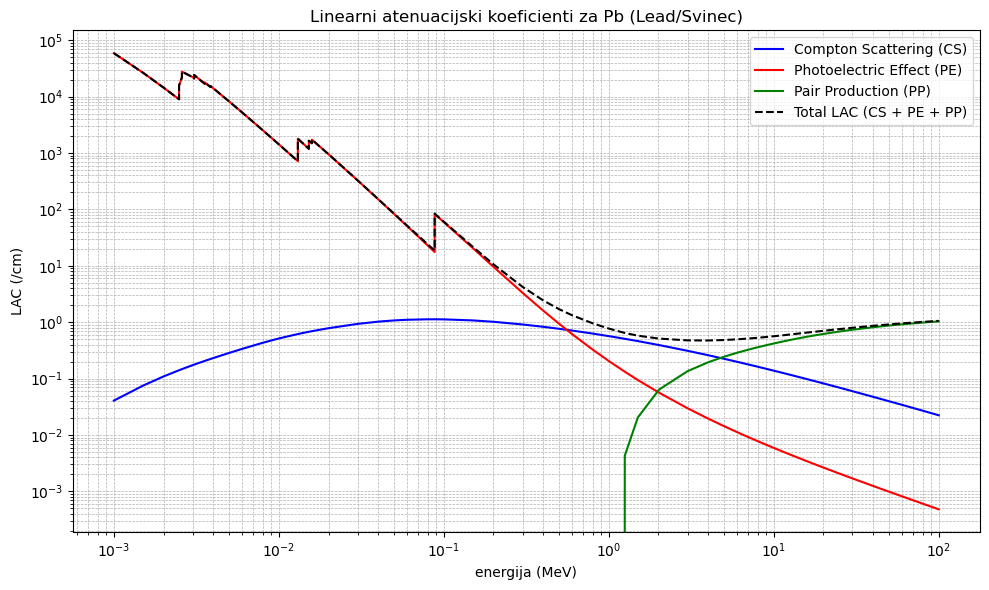

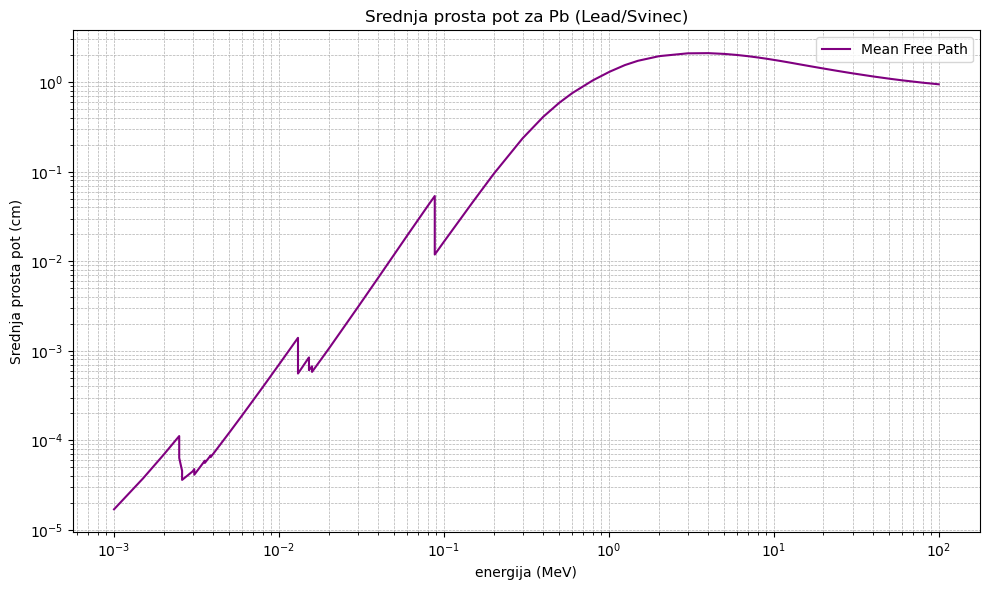

In [1]:
"""
Load a txt file with the data for the mac = mass attenuation coefficient of LEAD
Data is from NISC XCom database.
MAC is in units of cm^2/g
Columns:
 - Energy (MeV) [1kev - 10 MeV]
 - mac_coherent (Rayleigh scattering) [cm^2/g]
 - mac_incoherent (Compton scattering) [cm^2/g]
 - mac_photoelectric (Photoelectric effect) [cm^2/g]
 - mac_pair_production_nuclear (Pair production in nuclear field) [cm^2/g]
 - mac_pair_production_electron (Pair production in electron field) [cm^2/g]
 - mac_total (Total mass attenuation coefficient) [cm^2/g] - sum of all processes
 - mac_tot_w/o_coherent (Total mass attenuation coefficient without Rayleigh scattering) [cm^2/g]
"""

import importlib
from src import LinearAttenuationCoeff_load as LACload
importlib.reload(LACload)

path = "../mac_nistxcom/mac_lead.txt"
lead_density = 11.34  # g/cm^3
lead_lac_importer = LACload.LACLoader(path, lead_density, material_name="Pb (Lead/Svinec)")
energy_lead, lac_pp_lead, lac_cs_lead, lac_pe_lead, lac_total_lead = lead_lac_importer.get_lac_data()

#* gather lac data for simulation
LAC_data_lead = {
    'energy': energy_lead,  # Energy values for the linear attenuation coefficients
    'lac_cs': lac_cs_lead,  # Linear attenuation coefficient for Compton scattering
    'lac_pe': lac_pe_lead,  # Linear attenuation coefficient for photoelectric effect
    'lac_pp': lac_pp_lead,  # Linear attenuation coefficient for pair production
}

energies = [0.01,0.05,0.08,0.1,0.15,0.5,1.0,2.0] # MeV

for energy in energies:
    lac_value = lead_lac_importer.get_lac_at_energy(energy)
    print(f"At {energy} MeV, total linear attenuation coefficient is {lac_value:.4f} /cm"
          f"; (mean free path = {1/lac_value:.4f} cm)"
          )
    
# plot
lead_lac_importer.plot()
lead_lac_importer.plot_mean_free_path()

In [ ]:
class PhotonBoxSimulator:
    def __init__(self, BoxData, LAC_data, Emin_terminate=0.001):
        self.BoxData = BoxData
        self.LAC_data = LAC_data
        self.Emin_terminate = Emin_terminate
        
        # Define constants once at initialization instead of in methods
        self.m_e = 0.511  # Electron rest mass energy in MeV
        self.pair_production_threshold = 1.022  # MeV
        self.annihilation_energy = 0.511  # MeV per gamma in pair production
        
        # Pre-extract frequently used LAC data for efficiency
        self.energy_list = self.LAC_data['energy']
        self.lac_cs_list = self.LAC_data['lac_cs']
        self.lac_pe_list = self.LAC_data['lac_pe'] 
        self.lac_pp_list = self.LAC_data['lac_pp']
        
        # Pre-extract box geometry data
        self.cuboid_dimensions = self.BoxData['cuboid_dimensions']
        self.face_normals = self.BoxData['face_normals']
        self.r_faces = self.BoxData['r_faces']
        self.n_hvl = self.BoxData['n_hvl']  # Number of HVLs for the simulation
        self.n_hvl_leakage = self.BoxData['n_hvl_leakage']

    def SphericalToCartesian(self, theta, phi):
        x = np.cos(theta)
        y = np.sin(theta) * np.cos(phi)
        z = np.sin(theta) * np.sin(phi)
        return np.array([x, y, z])

    def NewDirectionUnitVector(self, u_old, theta_sc, phi_sc):
        u_old = u_old / np.linalg.norm(u_old) # necessary?
        u_sc_local = self.SphericalToCartesian(theta_sc, phi_sc)
        # if direction before scattering is close to initial direction of the beam, simple transform
        if np.allclose(u_old, [1, 0, 0]):
            return u_sc_local
        ref_vec = np.array([1, 0, 0])
        v = np.cross(ref_vec, u_old)
        v /= np.linalg.norm(v) # necessary?
        w = np.cross(u_old, v)
        R = np.column_stack((u_old, v, w))
        u_new = R @ u_sc_local
        u_new /= np.linalg.norm(u_new)
        return u_new

    def ComptonScatteringInteraction(self, E, u_particle):
        # Use pre-defined constant instead of defining it each time
        alpha = E / self.m_e
        eps_min = 1 / (1 + 2 * alpha)
        beta1 = - np.log(eps_min)
        beta2 = 0.5 * (1 - eps_min ** 2)
        while True:
            r1, r2, r3 = np.random.uniform(0, 1, 3)
            if r1 < beta1 / (beta1 + beta2):
                eps_prop = eps_min ** r2
            else:
                eps_prop = np.sqrt(eps_min ** 2 + (1 - eps_min ** 2) * r2)
            t = (1 - eps_prop) / alpha / eps_prop
            g_eps = 1 - eps_prop * t * (2 - t) / (1 + eps_prop ** 2)
            if g_eps > r3:
                eps = eps_prop
                break
        E_scattered = E * eps
        theta_cs = np.arccos(1 - 1 / alpha * (1 / eps - 1))
        phi_cs = 2 * np.pi * np.random.uniform(0, 1)
        u_new = self.NewDirectionUnitVector(u_particle, theta_cs, phi_cs)
        return E_scattered, u_new

    def PhotonFreePath(self, E):
        # Use pre-extracted data instead of accessing dictionary each time
        lac_cs = np.interp(E, self.energy_list, self.lac_cs_list)
        lac_pe = np.interp(E, self.energy_list, self.lac_pe_list)
        u1, u2, u3 = np.random.uniform(0, 1, 3)
        s_cs = - np.log(u1) / lac_cs
        s_pe = - np.log(u2) / lac_pe
        if E > self.pair_production_threshold:  # Use pre-defined constant
            lac_pp = np.interp(E, self.energy_list, self.lac_pp_list)
            s_pp = - np.log(u3) / lac_pp
        else:
            s_pp = np.inf
        free_path_length = min(s_cs, s_pe, s_pp)
        if free_path_length == s_cs:
            interaction_type = 'compton'
        elif free_path_length == s_pe:
            interaction_type = 'phot'
        else:
            interaction_type = 'pair'
        return free_path_length, interaction_type

    def BoxPathLength3D(self, r_particle, u_particle):
        min_path_length = np.inf
        exit_plane_index = -1
        for plane_index in range(6):
            r_plane, n_plane = self.r_faces[plane_index], self.face_normals[plane_index]
            relative_direction_scaling_factor = np.dot(u_particle, n_plane)
            if relative_direction_scaling_factor <= 0:
                continue
            path_length_to_plane = np.abs(np.dot(n_plane, r_particle - r_plane)) / relative_direction_scaling_factor
            if path_length_to_plane < min_path_length:
                min_path_length = path_length_to_plane
                exit_plane_index = plane_index
        return min_path_length, exit_plane_index

    def ParticleStep(self, PreStepParticleInfo):
        r_particle = PreStepParticleInfo['r']
        u_particle = PreStepParticleInfo['u']
        E = PreStepParticleInfo['E']
        eid = PreStepParticleInfo['eid']
        tid = PreStepParticleInfo['tid']

        add_photons_to_simulate = [] 
        box_path_length, exit_plane_index = self.BoxPathLength3D(r_particle, u_particle)
        free_path_length, interaction_type = self.PhotonFreePath(E)
        
        if free_path_length > box_path_length:
            interaction_type = 'exit'
            step_length = box_path_length
            E_dep = 0.0
            E_new = E
            #print(f"   --->Particle exited the box at face index {exit_plane_index} and energy {E_new:.4f} MeV")
            u_new = u_particle
            r_new = r_particle + box_path_length * u_particle
            particle_termination = True
            #event_termination = True  ## this is more complex, we will set it later
        else:
            r_new = r_particle + free_path_length * u_particle
            step_length = free_path_length
            exit_plane_index = -1
            if interaction_type == 'compton':
                E_new, u_new = self.ComptonScatteringInteraction(E, u_particle)
                E_dep = E - E_new
                # only in CS, the condition about termination based on energy is checked, is E is low enough, we terminate the particle
                if E_new < self.Emin_terminate:
                    particle_termination = True
                # if E_new >= self.Emin_terminate; then we add the photon to the list to simulate
                else:
                    particle_termination = False
                    add_photons_to_simulate.append({
                        'eid': eid,
                        'tid': tid,
                        'E': E_new,
                        'u': u_new,
                        'r': r_new,
                    })
            elif interaction_type == 'phot':
                E_new = 0.0
                E_dep = E
                u_new = None
                particle_termination = True
            elif interaction_type == 'pair':
                E_new = 0.0
                E_dep = E - self.pair_production_threshold  # Use pre-defined constant
                u_new = None
                particle_termination = True
                phi = np.random.uniform(0, 2 * np.pi)
                th = np.arccos(np.random.uniform(-1, 1))
                x, y, z = np.sin(th) * np.cos(phi), np.sin(th) * np.sin(phi), np.cos(th)
                u_pp = np.array([x, y, z])
                add_photons_to_simulate.extend([
                    {'eid': eid, 'tid': tid + 1, 'E': self.annihilation_energy, 'u': u_pp, 'r': r_new},  # Use pre-defined constant
                    {'eid': eid, 'tid': tid + 2, 'E': self.annihilation_energy, 'u': -u_pp, 'r': r_new}  # Use pre-defined constant
                ])
            elif interaction_type == 'exit':
                pass  # already set above
            else:
                raise RuntimeError("Unknown interaction type")
            
        PostStepParticleInfo = {
            'eid': eid,
            'tid': tid,
            'r': r_new,
            'u': u_new,
            'E': E_new,
        }
        
        return {
            'eid': eid,
            'tid': tid,
            
            #'PreStepParticleInfo': PreStepParticleInfo,  # Original particle info before the step
            #'PostStepParticleInfo': PostStepParticleInfo,  # Particle info after the step

            'E_prestep': E,  # Original energy before the step
            'r_prestep': r_particle,  # Original position before the step
            'u_prestep': u_particle,  # Original direction before the step
            
            #'free_path_length': free_path_length,
            #'box_path_length': box_path_length,
            #'step_length': step_length,
            
            'interaction': interaction_type,
            'exit_plane_index': exit_plane_index,
            'E_dep': E_dep,
            'add_photons_to_simulate': add_photons_to_simulate,

            'E_new': E_new,
            'u_new': u_new,
            'r_new': r_new,
            

            #'particle_termination': particle_termination,
            #'event_termination': event_termination,  ## this is not correct !!!!
            
            
            # anything else???
        }

    def PhotonPropagationSimulation(self, Nsim, SourcePhotons_template):
        """ Simulates the propagation of photons through a defined box geometry.
        Args:
            Nsim (int): Number of simulation events.
            SourcePhotons_template (dict): Template for the source photons, containing 'r', 'u', and 'E'.
        """
        Ephotons = SourcePhotons_template['E']
        #n_hvl = self.n_hvl
        print(f"Starting simulation: E={Ephotons}; n_hvl = {self.n_hvl}; {Nsim} events\n\n")

        # create a timestamped filename for saving simulation info
        timestamp_str = dt.now().strftime("%Y%m%d_%H%M%S")
        addinfo_filename = f"output_data/run_{timestamp_str}.txt"
        
        # lets add track of total energy that exists on the right size of the box - build-up contribution
        self.E_out_tot = 0.0
        self.E_deposited_tot = 0.0
        self.E_backscattered = 0.0
        self.E_leakage = 0.0

        for eid in range(Nsim):
            # Print progress every 10% of Nsim
            if eid % (Nsim // 10) == 0:
                print(f"Progress: {eid / Nsim * 100:.2f}%") 

            photons_to_simulate = [{
                'eid': eid,
                'tid': 0,
                'r': SourcePhotons_template['r'],
                'u': SourcePhotons_template['u'],
                'E': SourcePhotons_template['E'],
            }]
            
            
            while photons_to_simulate:
                # Process the first photon in the list
                PreStepData = photons_to_simulate.pop(0)
                # simulate the particle step
                result = self.ParticleStep(PreStepData)
                # extend the list of photons to simulate with new photons generated in this step
                photons_to_simulate.extend(result['add_photons_to_simulate'])
                
                # extract some data from the photon step 
                exit_plane_index = result['exit_plane_index']
                Edep = result['E_dep']
                Enew = result['E_new']



                #print(f"Event {result['eid']} | Track {result['tid']} | Interaction: {result['interaction']} | E_dep: {result['E_dep']:.4f} MeV")
                #print(result)
                #print("-->",len(photons_to_simulate), "photons to simulate after this step")
                

                # write the result to the file
                with open(addinfo_filename, "a") as f:
                    
                    # i) A more detailed output
                    # xint,yint,zint = result['r_new']
                    # num_photons_to_simulate = len(photons_to_simulate)
                    # f.write(
                    #     f" {result['eid']} {result['tid']} {result['interaction']} {exit_plane_index} "
                    #     f"{result['E_dep']:.4f} {result['E_new']} {xint} {yint} {zint} "
                    #     f"{result['u_new']} {num_photons_to_simulate}\n"
                    # )
                
                    # ii) A more compact output
                    xint, yint, zint = result['r_new']
                    # # this needs change
                    # f.write(
                    #     f" {result['eid']} {result['tid']} {result['interaction']} {result['E_dep']:.4f}"
                    #     f" {xint} {yint} {zint}\n"    
                    # )

                    # iii) Output for Edep distribution
                    xint, yint, zint = result['r_new']
                    f.write(
                        f"{Edep} {xint} {yint} {zint}\n"
                    )

                    ## iv) ...


                ## Build-up contribution, also add other faces and deposited energy
                # a) energy deposited insude the box
                if exit_plane_index == -1:
                    self.E_deposited_tot += Edep

                # b) - build-up contribution
                elif exit_plane_index == 0:  # Assuming exit_plane_index 0 is the right side of the box
                    self.E_out_tot += Enew
                    #print(f"Total energy on the right side of the box: {self.E_out_tot:.4f} MeV")

                # c) backscattered photons - exit on the face where they entered
                elif exit_plane_index == 1:  # Assuming exit_plane_index 2 is the back side of the box
                    self.E_backscattered += Enew
                    
                # d) leakage photons - exit on the side faces of the box
                else:
                    self.E_leakage += Enew






## List vs set ??

In [ ]:
import time 
Nsim = 12345000
progress_report_freq = 10  # %
eid_progress_list = list(
    int(Nsim * pct / 100)
    for pct in range(progress_report_freq, 101, progress_report_freq)
)
eid_progress_set = list(
    int(Nsim * pct / 100)
    for pct in range(progress_report_freq, 101, progress_report_freq)
)

print(f"{eid_progress_set}\n")

t_start = time.time()
for i in range(Nsim):
    if i in eid_progress_set:
    #if i in eid_progress_list:
        print(f"Number {i} is in the set!")
print(f"Loop lasted {time.time() - t_start} seconds!")

[1234500, 2469000, 3703500, 4938000, 6172500, 7407000, 8641500, 9876000, 11110500, 12345000]

Number 1234500 is in the set!
Number 2469000 is in the set!
Number 3703500 is in the set!
Number 4938000 is in the set!
Number 6172500 is in the set!
Number 7407000 is in the set!
Number 8641500 is in the set!
Number 9876000 is in the set!
Number 11110500 is in the set!
Loop lasted 3.474583864212036 seconds!


In [26]:
"""
Comments ...
"""

hvl_defined_cuboid = True
Ephotons = 5.0
n_hvl = 2
n_hvl_leakage = max(3*n_hvl, 10) # side dimensions of the cuboid, we wish they are "large", so we have no leakage of photons in those directions

if hvl_defined_cuboid:
    lac_Ephotons = np.interp(Ephotons, energy_lead, lac_total_simulation_lead)
    hvl = np.log(2) / lac_Ephotons  # Calculate the half-value layer in cm
    print(f"Half-value layer (HVL) for lead at {Ephotons} MeV: {hvl:.4f} cm")
    # define cuboid dimensions based on the HVL
    # 1. length - ...
    cuboid_length = n_hvl * hvl  # Length of the cuboid in cm
    # 2. width and height - we wish they are "large", so we have no leakage of photons in those directions
    cuboid_width = 2*n_hvl_leakage * hvl  # Width of the cuboid in cm
    cuboid_height = 2 * n_hvl_leakage * hvl  # Height of the cuboid in cm

else:
    # if not defined by HVL, we define cuboid dimensions manually
    cuboid_length = 5  # Length of the cuboid in cm
    cuboid_width = 5  # Width of the cuboid in cm
    cuboid_height = 5  # Height of the cuboid in cm

cuboid_dimensions = (cuboid_length, cuboid_width, cuboid_height)  # Dimensions of the cuboid

# Define the face normals for the cuboid
nF = np.array([1, 0, 0])  # Front face normal
nB = np.array([-1, 0, 0])  # Back face normal
nL = np.array([0, 1, 0])  # Left face normal
nR = np.array([0, -1, 0])  # Right face normal
nT = np.array([0, 0, 1])  # Top face normal
nD = np.array([0, 0, -1])  # Down face normal
face_normals = [nF, nB, nL, nR, nT, nD]  # List of face normals

# Define r_plane for each face of the cuboid
rF = np.array([cuboid_length / 2, 0, 0])  # Front face position
rB = np.array([-cuboid_length / 2, 0, 0]) # Back face position
rL = np.array([0, cuboid_width / 2, 0])  # Left face position
rR = np.array([0, -cuboid_width / 2, 0])  # Right face position
rT = np.array([0, 0, cuboid_height / 2])  # Top face position
rD = np.array([0, 0, -cuboid_height / 2])  # Down face position
r_faces = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces


## pack all this in BoxData
BoxData = {
    'cuboid_dimensions': cuboid_dimensions,  # Dimensions of the cuboid
    'face_normals': face_normals,  # Normal vectors of the cuboid faces
    'r_faces': r_faces,  # Points on the cuboid faces
    'n_hvl': n_hvl,  # Number of HVLs for the simulation
    'n_hvl_leakage': n_hvl_leakage,  # Number of HVLs for the leakage simulation
}   

LAC_data = {
    'energy': energy_lead,  # Energy values for the linear attenuation coefficients
    'lac_cs': lac_cs_lead,  # Linear attenuation coefficient for Compton scattering 
    'lac_pe': lac_pe_lead,  # Linear attenuation coefficient for photoelectric effect
    'lac_pp': lac_pp_lead,  # Linear attenuation coefficient for pair production
}



Half-value layer (HVL) for lead at 5.0 MeV: 1.4348 cm


initialize monoenergetic photons, entering the cuboid on the left side, directed to the right (perpendicular to the left face)

In [55]:
# Test with a small simulation
x0 = -cuboid_length/2 + 10**-10

SourcePhotons_template_test = {
    'r': np.array([x0, 0.0, 0.0]), # Initial position of the photon source at left side of the cuboid (x0 is a small offset to avoid numerical issues)
    'u': np.array([1.0, 0.0, 0.0]),  # Initial direction towards the positive x-axis
    'E': Ephotons,  # Initial energy of the photons in MeV
}

# number of photons to simulate
Nsim = 10**5
#Nsim= 15


report on parameters before the siumulation


In [59]:
print("=== Simulation Parameter Report ===")
print(f"Photon energy (Ephotons): {Ephotons} MeV")
print(f"Half-value layer (HVL) for lead at {Ephotons} MeV: {hvl:.4f} cm")
print(f"Number of HVLs (n_hvl): {n_hvl}")
print(f"Number of HVLs for leakage (n_hvl_leakage): {n_hvl_leakage}")
print(f"Cuboid dimensions (length x width x height): {cuboid_length:.4f} cm x {cuboid_width:.4f} cm x {cuboid_height:.4f} cm")
print(f"Initial photon position (x0): {x0:.4f} cm")
print(f"Initial photon direction: {SourcePhotons_template_test['u']}")
print("===================================")
print("Number of photons to simulate:", Nsim)


=== Simulation Parameter Report ===
Photon energy (Ephotons): 5.0 MeV
Half-value layer (HVL) for lead at 5.0 MeV: 1.4348 cm
Number of HVLs (n_hvl): 2
Number of HVLs for leakage (n_hvl_leakage): 10
Cuboid dimensions (length x width x height): 2.8696 cm x 28.6963 cm x 28.6963 cm
Initial photon position (x0): -1.4348 cm
Initial photon direction: [1. 0. 0.]
Number of photons to simulate: 100000


time to simulate
-

In [56]:
# Create the simulator instance
simulator = PhotonBoxSimulator(BoxData, LAC_data, Emin_terminate=0.001)
pp_simulation = simulator.PhotonPropagationSimulation(Nsim=Nsim, SourcePhotons_template=SourcePhotons_template_test)

# extract the total energy on the right side of the box
print(f"\nTotal energy on the right side of the box after simulation: {simulator.E_out_tot:.4f} MeV")

Starting simulation: E=5.0; n_hvl = 2; 100000 events


Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%

Total energy on the right side of the box after simulation: 155983.6212 MeV


calculate build-up factor

In [60]:
E_out_tot = simulator.E_out_tot  # Total energy on the right side of the box after simulation
E_theoretical = Ephotons * Nsim * np.exp(-n_hvl * np.log(2))  # Theoretical energy on the right side of the box
print(f"Theoretical energy on the right side of the box: {E_theoretical:.4f} MeV")
print(f"Total energy on the right side of the box: {E_out_tot:.4f} MeV")
# buildup
Buildup = E_out_tot / E_theoretical
print(f"Build-up factor: {Buildup:.4f}")

Theoretical energy on the right side of the box: 125000.0000 MeV
Total energy on the right side of the box: 155983.6212 MeV
Build-up factor: 1.2479


analyse total energy distribution

In [64]:
E_out = simulator.E_out_tot  # Total energy on the right side of the box after simulation
E_deposited = simulator.E_deposited_tot  # Total energy deposited inside the box
E_backscattered = simulator.E_backscattered  # Total energy backscattered
E_leakage = simulator.E_leakage  # Total energy leaked through the side faces of the box
E_tot_simulation = Ephotons * Nsim
E_tot_simulation = E_out + E_deposited + E_backscattered + E_leakage

print("\n=== Simulation Results ===")
print(f"Total energy detected on the right side of the box: {E_out:.4f} MeV ({E_out / E_tot_simulation * 100:.2f}% of total energy)")
print(f"Total energy deposited inside the box: {E_deposited:.4f} MeV ({E_deposited / E_tot_simulation * 100:.2f}% of total energy)")
print(f"Total energy backscattered: {E_backscattered:.4f} MeV ({E_backscattered / E_tot_simulation * 100:.2f}% of total energy)")
print(f"Total energy leaked through the side faces of the box: {E_leakage:.4f} MeV")    
print(f"Total energy in the simulation: {E_out + E_deposited + E_backscattered + E_leakage:.4f} MeV")   

# compare total energy detected to the total initial energy of all photons
print(f"\nTotal initial energy of all photons: {E_tot_simulation:.4f} MeV")
print(f"Total energy detected in the simulation: {E_out + E_deposited + E_backscattered + E_leakage:.4f} MeV")





=== Simulation Results ===
Total energy detected on the right side of the box: 155983.6212 MeV (31.20% of total energy)
Total energy deposited inside the box: 340071.9421 MeV (68.01% of total energy)
Total energy backscattered: 3944.4367 MeV (0.79% of total energy)
Total energy leaked through the side faces of the box: 0.0000 MeV
Total energy in the simulation: 500000.0000 MeV

Total initial energy of all photons: 500000.0000 MeV
Total energy detected in the simulation: 500000.0000 MeV


---
---
## Energy deposited distribution

position-to-voxel translator

In [46]:
class VoxelTranslator:
    def __init__(self, detector_shape, voxel_size):
        """
        Initialize the VoxelTranslator with constant parameters.

        Args:
            detector_shape (tuple): Shape of the detector (length, width, depth).
            voxel_size (tuple): Size of each voxel (x, y, z).
            doShiftZeroIndex (bool): Whether to shift indices to start from 1  - ommited completely now
        """
        self.detector_length, self.detector_width, self.detector_depth = detector_shape
        self.voxel_size = voxel_size
        #self.doShiftZeroIndex = doShiftZeroIndex

    def translate(self, loc):
        """
        Translate a location to voxel indices.

        Args:
            loc (tuple): Location (x, y, z) in mm.

        Returns:
            tuple: Voxel indices (i, j, k).
        """
        x, y, z = loc

        # Convert from location to voxel index
        i = int(np.floor((x + self.detector_length / 2) / self.voxel_size[0]))
        j = int(np.floor((y + self.detector_width / 2) / self.voxel_size[1]))
        k = int(np.floor((z + self.detector_depth / 2) / self.voxel_size[2]))

        # Handle edge case where location is exactly on the max edge of the detector
        if x == self.detector_length / 2:
            #print("x location is exactly on the max edge of the detector")
            i = int(self.detector_length / self.voxel_size[0]) - 1
        if y == self.detector_width / 2:
            #print("y location is exactly on the max edge of the detector")
            j = int(self.detector_width / self.voxel_size[1]) - 1
        if z == self.detector_depth / 2:
            #print("z location is exactly on the max edge of the detector")
            k = int(self.detector_depth / self.voxel_size[2]) - 1


        return i, j, k
    
  ## some testing so i see how it works

## A) Example - testing!!

# 1. define detector shape and voxel size
detector_shape = (120,80,2)
# Voxel dimensions in mm
voxel_size = (1, 1, 0.545)
# print det shape, voxel, size
print(f"Detector shape: {detector_shape}")
print(f"Voxel size: {voxel_size}")
# number of voxels in each dimension
n_voxels_x = int(detector_shape[0] / voxel_size[0])
n_voxels_y = int(detector_shape[1] / voxel_size[1])
n_voxels_z = int(detector_shape[2] / voxel_size[2])
print(f"Number of voxels: {n_voxels_x} x {n_voxels_y} x {n_voxels_z}")

# 2. define location - shall be between -detector_size/2 and +detector_size/2 for each axis 
x_scale = -1
y_scale = -0.845
z_scale = -0.956
xloc = x_scale * detector_shape[0]/2
yloc = y_scale * detector_shape[1]/2
zloc = z_scale * detector_shape[2]/2  # z is always 0 in this case
loc = (xloc,yloc,zloc)
# print location of interaction
print(f"Location of interaction: {loc}")

# 3. create translator and translate location
translator = VoxelTranslator(detector_shape, voxel_size)
# 4. translate location
voxel_indices = translator.translate(loc)
# print voxel indices
print(f"Voxel indices: {voxel_indices}")




# B) Test this on our cuboid
print('\n\n')
detector_shape = (cuboid_length, cuboid_width, cuboid_height)
voxel_size = (0.1, 0.1, 0.1)  # Voxel size in cm
print(f"Detector shape: {detector_shape}")
print(f"Voxel size: {voxel_size}")
# Number of voxels in each dimension
n_voxels_x = int(detector_shape[0] / voxel_size[0])
n_voxels_y = int(detector_shape[1] / voxel_size[1])
n_voxels_z = int(detector_shape[2] / voxel_size[2])
print(f"Number of voxels: {n_voxels_x} x {n_voxels_y} x {n_voxels_z}")



# Create the VoxelTranslator instance
translator = VoxelTranslator(detector_shape, voxel_size)

# Example location in the cuboid
xloc = 0.0  # Center of the cuboid
yloc = 0.0  # Center of the cuboid
zloc = 0.0  # Center of the cuboid
loc = (xloc, yloc, zloc)
print(f"Location of interaction: {loc}")

voxel_indices = translator.translate(loc)
print(f"Voxel indices: {voxel_indices}")




Detector shape: (120, 80, 2)
Voxel size: (1, 1, 0.545)
Number of voxels: 120 x 80 x 3
Location of interaction: (-60.0, -33.8, -0.956)
Voxel indices: (0, 6, 0)



Detector shape: (2.8696291067805633, 28.69629106780563, 28.69629106780563)
Voxel size: (0.1, 0.1, 0.1)
Number of voxels: 28 x 286 x 286
Location of interaction: (0.0, 0.0, 0.0)
Voxel indices: (14, 143, 143)


In [67]:
# Define voxel dimensions (already defined above, but you can change if needed)
voxel_size = (0.1, 0.1, 0.1)  # in cm

# Use the cuboid dimensions already defined
detector_shape = (cuboid_length, cuboid_width, cuboid_height)

# Number of voxels in each dimension
n_voxels_x = int(detector_shape[0] / voxel_size[0])
n_voxels_y = int(detector_shape[1] / voxel_size[1])
n_voxels_z = int(detector_shape[2] / voxel_size[2])

# Initialize the energy deposition array
energy_deposition = np.zeros((n_voxels_x, n_voxels_y, n_voxels_z))

# Create the VoxelTranslator instance
translator = VoxelTranslator(detector_shape, voxel_size)

# Read the txt file and accumulate energy deposition per voxel
filename = "Run1e5"
with open("output_data/" + filename + ".txt", "r") as f:  # Replace * with your actual timestamp
    for line in f:
        Edep_str, x_str, y_str, z_str = line.strip().split()
        Edep = float(Edep_str)
        x = float(x_str)
        y = float(y_str)
        z = float(z_str)
        voxel_idx = translator.translate((x, y, z))
        i, j, k = voxel_idx
        # Check bounds to avoid indexing errors
        if 0 <= i < n_voxels_x and 0 <= j < n_voxels_y and 0 <= k < n_voxels_z:
            energy_deposition[i, j, k] += Edep

# Now energy_deposition contains the total energy deposited in each voxel

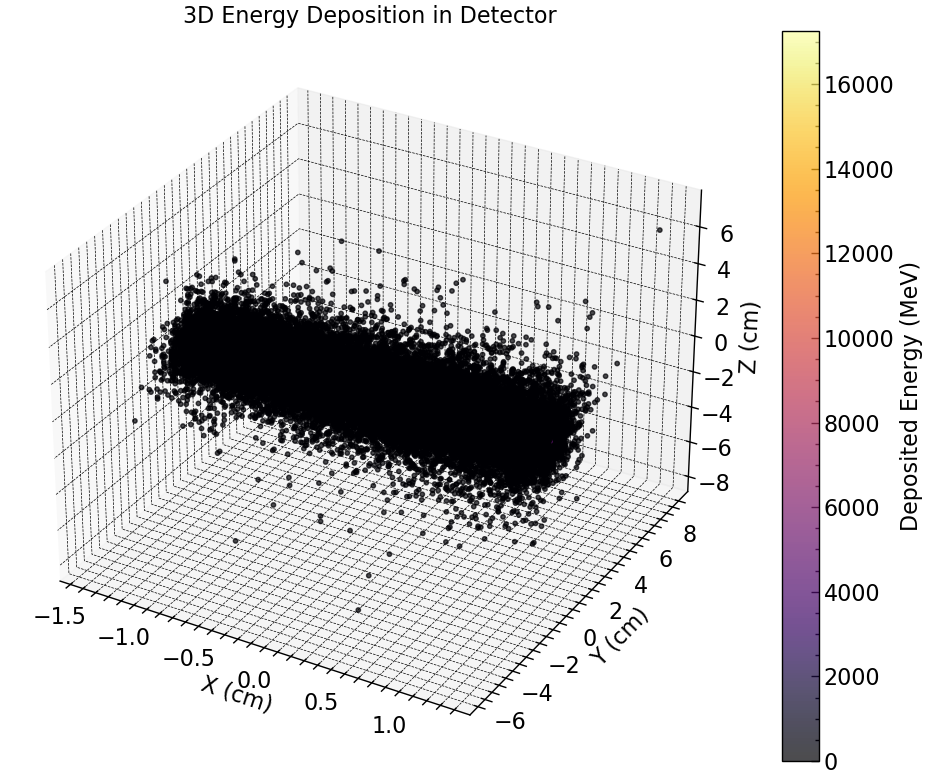

In [68]:
from mpl_toolkits.mplot3d import Axes3D

# Get nonzero voxel indices and their energy values
nonzero_indices = np.nonzero(energy_deposition)
energies = energy_deposition[nonzero_indices]

# Convert voxel indices to physical coordinates (center of voxel)
x_coords = (np.array(nonzero_indices[0]) + 0.5) * voxel_size[0] - detector_shape[0] / 2
y_coords = (np.array(nonzero_indices[1]) + 0.5) * voxel_size[1] - detector_shape[1] / 2
z_coords = (np.array(nonzero_indices[2]) + 0.5) * voxel_size[2] - detector_shape[2] / 2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_coords, y_coords, z_coords, c=energies, cmap='inferno', marker='o', s=10, alpha=0.7)
plt.colorbar(sc, ax=ax, label='Deposited Energy (MeV)')
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title('3D Energy Deposition in Detector')
plt.tight_layout()
plt.show()

-------------------------
----------------------

-----

analysis for different parameters
-

In [49]:
# Simulate for Ephotons=5 and HVL from 1 to 10, Nsim=10**5 for each
buildup_factors = []
hvl_range = np.arange(1, 11)
Ephotons = 5.0
Nsim = 10**5

for n_hvl_test in hvl_range:
    lac_Ephotons = np.interp(Ephotons, energy_lead, lac_total_simulation_lead)
    hvl = np.log(2) / lac_Ephotons
    cuboid_length = n_hvl_test * hvl
    cuboid_width = 2 * n_hvl_leakage * hvl
    cuboid_height = 2 * n_hvl_leakage * hvl
    cuboid_dimensions = (cuboid_length, cuboid_width, cuboid_height)
    rF = np.array([cuboid_length / 2, 0, 0])
    rB = np.array([-cuboid_length / 2, 0, 0])
    rL = np.array([0, cuboid_width / 2, 0])
    rR = np.array([0, -cuboid_width / 2, 0])
    rT = np.array([0, 0, cuboid_height / 2])
    rD = np.array([0, 0, -cuboid_height / 2])
    r_faces = [rF, rB, rL, rR, rT, rD]
    BoxData_test = {
        'cuboid_dimensions': cuboid_dimensions,
        'face_normals': face_normals,
        'r_faces': r_faces,
        'n_hvl': n_hvl_test,
        'n_hvl_leakage': n_hvl_leakage,
    }
    LAC_data_test = {
        'energy': energy_lead,
        'lac_cs': lac_cs_lead,
        'lac_pe': lac_pe_lead,
        'lac_pp': lac_pp_lead,
    }
    simulator_test = PhotonBoxSimulator(BoxData_test, LAC_data_test, Emin_terminate=0.001)
    x0 = -cuboid_length / 2 + 1e-10
    SourcePhotons_template_test = {
        'r': np.array([x0, 0.0, 0.0]),
        'u': np.array([1.0, 0.0, 0.0]),
        'E': Ephotons,
    }
    simulator_test.PhotonPropagationSimulation(Nsim=Nsim, SourcePhotons_template=SourcePhotons_template_test)
    E_out_tot = simulator_test.E_out_tot
    E_theoretical = Ephotons * Nsim * np.exp(-n_hvl_test * np.log(2))
    buildup = E_out_tot / E_theoretical
    buildup_factors.append(buildup)
    print(f"HVL={n_hvl_test}: Buildup={buildup:.4f}")

# plt.figure(figsize=(8, 5))
# plt.plot(hvl_range, buildup_factors, marker='o')
# plt.xlabel('Number of HVLs')
# plt.ylabel('Build-up Factor')
# plt.title('Build-up Factor vs Number of HVLs (Ephotons=5 MeV)')
# plt.grid(True)
# plt.show()

Starting simulation: E=5.0; n_hvl = 5; 100000 events...
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
HVL=1: Buildup=1.1215
Starting simulation: E=5.0; n_hvl = 5; 100000 events...
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
HVL=2: Buildup=1.2386
Starting simulation: E=5.0; n_hvl = 5; 100000 events...
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
HVL=3: Buildup=1.3616
Starting simulation: E=5.0; n_hvl = 5; 100000 events...
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
HVL=4: Buildup=1.4914
Starting sim

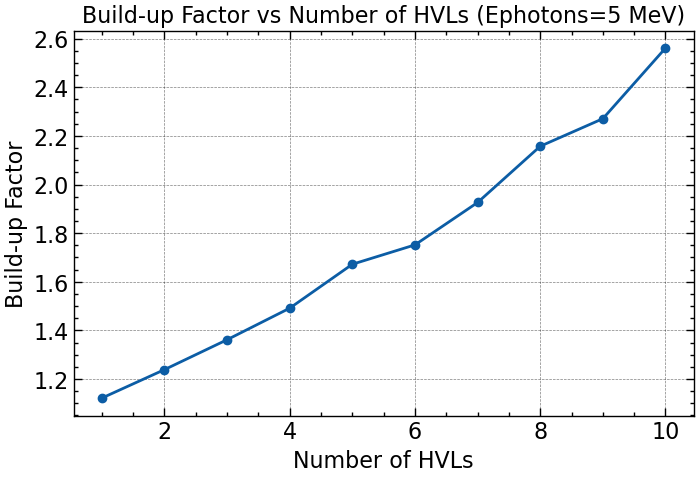

In [50]:
plt.figure(figsize=(8, 5))
plt.plot(hvl_range, buildup_factors, marker='o')
plt.xlabel('Number of HVLs')
plt.ylabel('Build-up Factor')
plt.title('Build-up Factor vs Number of HVLs (Ephotons=5 MeV)')
plt.grid(True)
plt.show()